# Simple Keras Starter

EDITS: 
- Added rescaling in image preprocessing for better NN stability
- Cleared the clutter in `imshow_group()` function

This is a simple 5 layer CNN model built with keras. It gets a score of around 0.75 on the leaderboard.

In [2]:
# Importing necessary libraries
import numpy as np
import os
import glob
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import pickle

from keras.utils import to_categorical, plot_model
from keras.layers import Dense, Input, Conv2D, Flatten, MaxPool2D, Activation
from keras.models import Model, Sequential
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras import backend as K


In [3]:
#Declaring constants
FIG_WIDTH=20 # Width of figure
ROW_HEIGHT=3 # Height of each row when showing a figure which consists of multiple rows
RESIZE_DIM=28 # The images will be resized to 28x28 pixels

# Setup path variables


In [4]:
#data_dir=os.path.join('..','NumtaDB_with_aug')
data_dir=os.path.join('..','/home/hasib/Hasib/Others/NumtaDB_with_aug')
paths_train_a=glob.glob(os.path.join(data_dir,'training-a','*.png'))
paths_train_b=glob.glob(os.path.join(data_dir,'training-b','*.png'))
paths_train_e=glob.glob(os.path.join(data_dir,'training-e','*.png'))
paths_train_c=glob.glob(os.path.join(data_dir,'training-c','*.png'))
paths_train_d=glob.glob(os.path.join(data_dir,'training-d','*.png'))
paths_train_all=paths_train_a+paths_train_b+paths_train_c+paths_train_d+paths_train_e

paths_test_a=glob.glob(os.path.join(data_dir,'testing-a','*.png'))
paths_test_b=glob.glob(os.path.join(data_dir,'testing-b','*.png'))
paths_test_e=glob.glob(os.path.join(data_dir,'testing-e','*.png'))
paths_test_c=glob.glob(os.path.join(data_dir,'testing-c','*.png'))
paths_test_d=glob.glob(os.path.join(data_dir,'testing-d','*.png'))
paths_test_f=glob.glob(os.path.join(data_dir,'testing-f','*.png'))+glob.glob(os.path.join(data_dir,'testing-f','*.JPG'))
paths_test_auga=glob.glob(os.path.join(data_dir,'testing-auga','*.png'))
paths_test_augc=glob.glob(os.path.join(data_dir,'testing-augc','*.png'))
paths_test_all=paths_test_a+paths_test_b+paths_test_c+paths_test_d+paths_test_e+paths_test_f+paths_test_auga+paths_test_augc

path_label_train_a=os.path.join(data_dir,'training-a.csv')
path_label_train_b=os.path.join(data_dir,'training-b.csv')
path_label_train_e=os.path.join(data_dir,'training-e.csv')
path_label_train_c=os.path.join(data_dir,'training-c.csv')
path_label_train_d=os.path.join(data_dir,'training-d.csv')

# Utility Functions

In [5]:
def get_key(path):
    # seperates the key of an image from the filepath
    key=path.split(sep=os.sep)[-1]
    return key

def get_data(paths_img,path_label=None,resize_dim=None):
    '''reads images from the filepaths, resizes them (if given), and returns them in a numpy array
    Args:
        paths_img: image filepaths
        path_label: pass image label filepaths while processing training data, defaults to None while processing testing data
        resize_dim: if given, the image is resized to resize_dim x resize_dim (optional)
    Returns:
        X: group of images
        y: categorical true labels
    '''
    X=[] # initialize empty list for resized images
    for i,path in enumerate(paths_img):
        img=cv2.imread(path,cv2.IMREAD_COLOR) # images loaded in color (BGR)
        img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        if resize_dim is not None:
            img=cv2.resize(img,(resize_dim,resize_dim),interpolation=cv2.INTER_AREA) # resize image to 28x28
#         X.append(np.expand_dims(img,axis=2)) # expand image to 28x28x1 and append to the list.
        X.append(img) # expand image to 28x28x1 and append to the list
        # display progress
        if i==len(paths_img)-1:
            end='\n'
        else: end='\r'
        print('processed {}/{}'.format(i+1,len(paths_img)),end=end)
        
    X=np.array(X) # tranform list to numpy array
    if  path_label is None:
        return X
    else:
        df = pd.read_csv(path_label) # read labels
        df=df.set_index('filename') 
        y_label=[df.loc[get_key(path)]['digit'] for path in  paths_img] # get the labels corresponding to the images
        y=to_categorical(y_label,10) # transfrom integer value to categorical variable
        return X, y

def imshow_group(X,y=None,y_pred=None,n_per_row=10):
    '''helper function to visualize a group of images along with their categorical true labels (y) and prediction probabilities.
    Args:
        X: images
        y: categorical true labels
        y_pred: predicted class probabilities
        n_per_row: number of images per row to be plotted
    '''
    n_sample=len(X)
    img_dim=X.shape[1]
    j=np.ceil(n_sample/n_per_row)
    fig=plt.figure(figsize=(FIG_WIDTH,ROW_HEIGHT*j))
    for i,img in enumerate(X):
        plt.subplot(j,n_per_row,i+1)
        plt.imshow(img)
        if y is not None:
                plt.title('true label: {}'.format(np.argmax(y[i])))
        if y_pred is not None:
            top_n=3 # top 3 predictions with highest probabilities
            ind_sorted=np.argsort(y_pred[i])[::-1]
            h=img_dim+4
            for k in range(top_n):
                string='pred: {} ({:.0f}%)\n'.format(ind_sorted[k],y_pred[i,ind_sorted[k]]*100)
                plt.text(img_dim/2, h, string, horizontalalignment='center',verticalalignment='center')
                h+=4
        plt.axis('off')
    plt.show()
def create_submission(predictions,keys,path):
    result = pd.DataFrame(
        predictions,
        columns=['label'],
        index=keys
        )
    result.index.name='key'
    result.to_csv(path, index=True)

# Preprocess data

In [6]:
X_train_a,y_train_a=get_data(paths_train_a,path_label_train_a,resize_dim=RESIZE_DIM)
X_train_b,y_train_b=get_data(paths_train_b,path_label_train_b,resize_dim=RESIZE_DIM)
X_train_c,y_train_c=get_data(paths_train_c,path_label_train_c,resize_dim=RESIZE_DIM)
X_train_d,y_train_d=get_data(paths_train_d,path_label_train_d,resize_dim=RESIZE_DIM)
X_train_e,y_train_e=get_data(paths_train_e,path_label_train_e,resize_dim=RESIZE_DIM)

processed 19702/19702
processed 359/359
processed 24298/24298
processed 10908/10908
processed 16778/16778


In [7]:
X_train_all=np.concatenate((X_train_a,X_train_b,X_train_c,X_train_d,X_train_e),axis=0)
y_train_all=np.concatenate((y_train_a,y_train_b,y_train_c,y_train_d,y_train_e),axis=0)
X_train_all.shape, y_train_all.shape

((72045, 28, 28, 3), (72045, 10))

In [8]:
X_test_a=get_data(paths_test_a,resize_dim=RESIZE_DIM)
X_test_b=get_data(paths_test_b,resize_dim=RESIZE_DIM)
X_test_c=get_data(paths_test_c,resize_dim=RESIZE_DIM)
X_test_d=get_data(paths_test_d,resize_dim=RESIZE_DIM)
X_test_e=get_data(paths_test_e,resize_dim=RESIZE_DIM)
X_test_f=get_data(paths_test_f,resize_dim=RESIZE_DIM)
X_test_auga=get_data(paths_test_auga,resize_dim=RESIZE_DIM)
X_test_augc=get_data(paths_test_augc,resize_dim=RESIZE_DIM)

processed 3489/3489
processed 69/69
processed 4381/4381
processed 1948/1948
processed 2970/2970
processed 495/495
processed 2168/2168
processed 2106/2106


In [9]:
X_test_all=np.concatenate((X_test_a,X_test_b,X_test_c,X_test_d,X_test_e,X_test_f,X_test_auga,X_test_augc))

Next, we are going to randomly choose 80% of the training data and use it to train our neural network. The remaining 20% images are going to be our validation data.

In [10]:

"""
X_train_a_48=np.array([get_data(path,resize_dim=28) for path in paths_train_a])
# train data
X_train_48=X_train_a_48[indices[:ind]] 
# validation data
X_val_48=X_train_a_48[indices[-(len(indices)-ind):]] 
"""
indices=list(range(len(X_train_all)))
np.random.seed(42)
np.random.shuffle(indices)

ind=int(len(indices)*0.80)
# train data
X_train=X_train_all[indices[:ind]] 
y_train=y_train_all[indices[:ind]]
# validation data
X_val=X_train_all[indices[-(len(indices)-ind):]] 
y_val=y_train_all[indices[-(len(indices)-ind):]]


# Model

We shall build a small model based on the classic [LeNet](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf) architecture. We shall use only three convolutional layers. Each convolution layer has rectified linear unit (ReLU) activation which is followed by a max pooling layer. The convolution layers are followed by two dense layers. 

In [19]:
"""
#from workshop 
def get_model():
    
    model=Sequential()
    
    model.add(Conv2D(filters=8,kernel_size=(5,5),padding='valid', activation='relu',input_shape=(RESIZE_DIM, RESIZE_DIM, 3)))
    model.add(MaxPool2D(pool_size=(2,2),strides=2,padding='valid'))
    
    model.add(Conv2D(filters=16,kernel_size=(3,3),padding='valid', activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2),strides=2,padding='valid'))
    
    model.add(Conv2D(filters=32,kernel_size=(3,3),padding='valid', activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2),strides=2,padding='valid'))
    
    #new layer
    #model.add(Conv2D(filters=64,kernel_size=(3,3),padding='same', activation='relu'))
    #model.add(MaxPool2D(pool_size=(2,2),strides=2,padding='same'))
    
    model.add(Flatten())
    model.add(Dense(units=64))
    model.add(Dense(units=10,activation='softmax'))
    
    model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')
    return model
model=get_model()
model.summary()
"""
#---------------------------------
def get_model():
    input_layer=Input(shape=(RESIZE_DIM,RESIZE_DIM,3))
    
    x=Conv2D(filters=8,kernel_size=(5,5),padding='valid', activation='relu')(input_layer)
    x=MaxPool2D(pool_size=(2,2),strides=2,padding='valid')(x)
    
    x=Conv2D(filters=16,kernel_size=(3,3),padding='valid', activation='relu')(x)
    x=MaxPool2D(pool_size=(2,2),strides=2,padding='valid')(x)
    
    x=Conv2D(filters=32,kernel_size=(3,3),padding='valid', activation='relu')(x)
    x=MaxPool2D(pool_size=(2,2),strides=2,padding='valid')(x)
    
    #new
    x=Conv2D(filters=64,kernel_size=(3,3),padding='same', activation='relu')(x)
    x=MaxPool2D(pool_size=(2,2),strides=2,padding='same')(x)
    
    x=Conv2D(filters=128,kernel_size=(3,3),padding='same', activation='relu')(x)
    x=MaxPool2D(pool_size=(2,2),strides=2,padding='same')(x)
    
    x=Conv2D(filters=256,kernel_size=(3,3),padding='same', activation='relu')(x)
    x=MaxPool2D(pool_size=(2,2),strides=2,padding='same')(x)
    
    #x=Conv2D(filters=128,kernel_size=(3,3),padding='valid', activation='relu')(x)
    #x=MaxPool2D(pool_size=(2,2),strides=2,padding='valid')(x)
    
    x=Flatten()(x)
    
    x=Dense(units=64)(x)
    x=Dense(units=10)(x) 
    
    output_layer=Activation('softmax')(x)
    model=Model(inputs=input_layer,outputs=output_layer)
    model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')
    return model
model=get_model()
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 28, 28, 3)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 24, 24, 8)         608       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 12, 12, 8)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 10, 10, 16)        1168      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 5, 5, 16)          0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 3, 3, 32)          4640      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 1, 1, 32)          0         
__________

# Train and Validate

In [20]:
path_model='model_simple_keras_starter.h5' # save model at this location after each epoch
K.tensorflow_backend.clear_session() # destroys the current graph and builds a new one
model=get_model() # create the model
K.set_value(model.optimizer.lr,1e-3) # set the learning rate

# fit the model
h=model.fit(x=X_train,     
            y=y_train, 
            batch_size=64, 
            epochs=150, 
            verbose=1, 
            validation_data=(X_val,y_val),
            shuffle=True,
            callbacks=[
                ModelCheckpoint(filepath=path_model),
            ]
            )


Train on 57636 samples, validate on 14409 samples
Epoch 1/150
57636/57636 [==============================] - 88s 2ms/step - loss: 1.1305 - acc: 0.5880 - val_loss: 0.6083 - val_acc: 0.7934
Epoch 2/150
57636/57636 [==============================] - 86s 1ms/step - loss: 0.5233 - acc: 0.8235 - val_loss: 0.4659 - val_acc: 0.8482
Epoch 3/150
57636/57636 [==============================] - 87s 2ms/step - loss: 0.4080 - acc: 0.8627 - val_loss: 0.3945 - val_acc: 0.8726
Epoch 4/150
57636/57636 [==============================] - 88s 2ms/step - loss: 0.3468 - acc: 0.8839 - val_loss: 0.3419 - val_acc: 0.8906
Epoch 5/150
57636/57636 [==============================] - 88s 2ms/step - loss: 0.3232 - acc: 0.8937 - val_loss: 0.3313 - val_acc: 0.8989
Epoch 6/150
57636/57636 [==============================] - 88s 2ms/step - loss: 0.2955 - acc: 0.9023 - val_loss: 0.3389 - val_acc: 0.8949
Epoch 7/150
57636/57636 [==============================] - 88s 2ms/step - loss: 0.2754 - acc: 0.9096 - val_loss: 0.3111 - 

Epoch 118/150
57636/57636 [==============================] - 86s 1ms/step - loss: 0.1007 - acc: 0.9719 - val_loss: 0.3268 - val_acc: 0.9348
Epoch 119/150
57636/57636 [==============================] - 85s 1ms/step - loss: 0.0978 - acc: 0.9716 - val_loss: 0.3998 - val_acc: 0.9194
Epoch 120/150
57636/57636 [==============================] - 88s 2ms/step - loss: 0.0849 - acc: 0.9743 - val_loss: 0.3537 - val_acc: 0.9290
Epoch 121/150
57636/57636 [==============================] - 87s 2ms/step - loss: 0.1070 - acc: 0.9688 - val_loss: 0.3119 - val_acc: 0.9389
Epoch 122/150
57636/57636 [==============================] - 86s 1ms/step - loss: 0.0859 - acc: 0.9747 - val_loss: 0.3109 - val_acc: 0.9406
Epoch 123/150
57636/57636 [==============================] - 87s 2ms/step - loss: 0.0855 - acc: 0.9750 - val_loss: 0.3373 - val_acc: 0.9343
Epoch 124/150
57636/57636 [==============================] - 87s 2ms/step - loss: 0.0937 - acc: 0.9723 - val_loss: 0.2996 - val_acc: 0.9398
Epoch 125/150
57636/

# Make Predictions on Test Set

In [21]:
predictions_prob=model.predict(X_test_all) # get predictions for all the testing data

Let's observe a few pedictions.

In [22]:
n_sample=200 #200
np.random.seed(42)
ind=np.random.randint(0,len(X_test_all), size=n_sample)

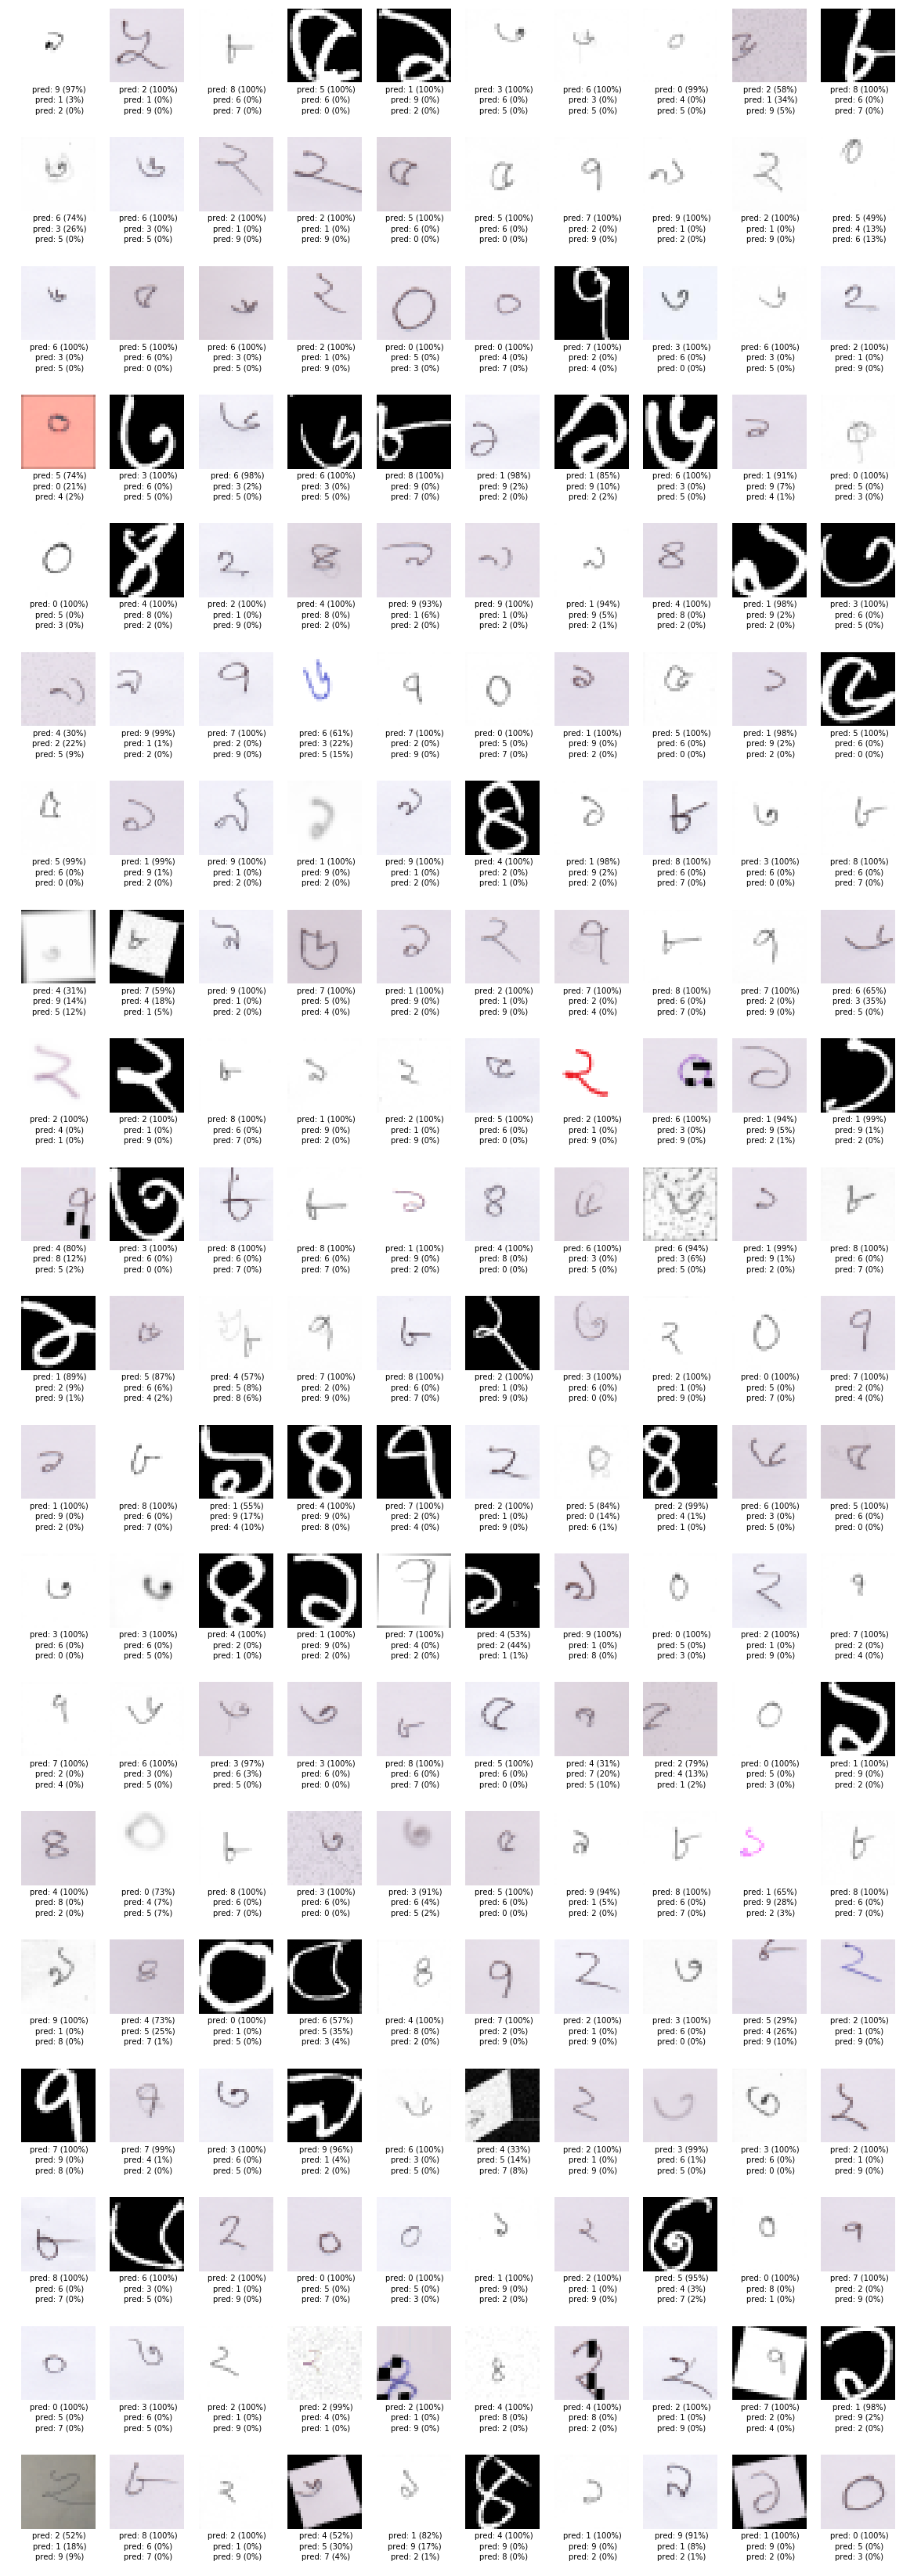

In [23]:
imshow_group(X=X_test_all[ind],y=None,y_pred=predictions_prob[ind])

# Create Submission

In [24]:
labels=[np.argmax(pred) for pred in predictions_prob]

In [25]:
keys=[get_key(path) for path in paths_test_all ]

In [26]:
create_submission(predictions=labels,keys=keys,path='hasib_keras_150epochs_june_4.csv')